In [1]:
import pdb;
import scipy.misc as scimisc

from tkinter import *
from PIL import Image
from PIL import ImageTk

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from PIL import Image

import MalmoPython
import os
import sys
import time
import random
import json
import numpy as np
import time
from IPython.display import clear_output,display
import logging
import math


import gym
import gym_minecraft
import itertools
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

import baselines.common.tf_util as U

from baselines import logger
from baselines import deepq
from baselines.deepq.replay_buffer import ReplayBuffer,PrioritizedReplayBuffer
from baselines.common.schedules import LinearSchedule

In [2]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from bokeh.driving import linear
from bokeh.layouts import row,gridplot
from IPython.display import clear_output,display
import bokeh
output_notebook()

Loading BokehJS ...

In [3]:
from keras import backend as K
from keras.models import Sequential,model_from_json,Model
from keras.layers import Conv2D,LSTM,GRU,TimeDistributed,Dense,Flatten,Input,Lambda
from keras.optimizers import RMSprop,Adam
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [4]:
import gym
import gym_minecraft
from MinecraftGym import MinecraftWrapper

## Epsilon Policies

In [5]:
class Policy:
    """Base class representing an MDP policy.

    Policies are used by the agent to choose actions.

    Policies are designed to be stacked to get interesting behaviors
    of choices. For instances in a discrete action space the lowest
    level policy may take in Q-Values and select the action index
    corresponding to the largest value. If this policy is wrapped in
    an epsilon greedy policy then with some probability epsilon, a
    random action will be chosen.
    """

    def select_action(self, **kwargs):
        """Used by agents to select actions.

        Returns
        -------
        Any:
          An object representing the chosen action. Type depends on
          the hierarchy of policy instances.
        """
        raise NotImplementedError('This method should be overriden.')

In [30]:
class LinearDecayGreedyEpsilonPolicy(Policy):
    """Policy with a parameter that decays linearly.

    Like GreedyEpsilonPolicy but the epsilon decays from a start value
    to an end value over k steps.

    Parameters
    ----------
    start_value: int, float
      The initial value of the parameter
    end_value: int, float
      The value of the policy at the end of the decay.
    num_steps: int
      The number of steps over which to decay the value.

    """

    def __init__(self, start_value, end_value, num_steps):  # noqa: D102
        self.start_value = start_value
        self.decay_rate = float(end_value - start_value) / num_steps
        self.end_value = end_value
        self.step = 0
        self.epsilon = start_value

    def update(self,is_training = True):
        """Decay parameter and select action.

        Parameters
        ----------
        q_values: np.array
          The Q-values for each action.
        is_training: bool, optional
          If true then parameter will be decayed. Defaults to true.

        Returns
        -------
        Any:
          Selected action.
        """
        epsilon = self.start_value
        if is_training:
            epsilon += self.decay_rate * self.step
            self.step += 1
        self.epsilon = max(epsilon, self.end_value)

    def reset(self):
        """Start the decay over at the start value."""
        self.step = 0


## Preprocessor

In [7]:
class Preprocessor:
    """Preprocessor base class.

    This is a suggested interface for the preprocessing steps. 

    Preprocessor can be used to perform some fixed operations on the
    raw state from an environment. For example, in ConvNet based
    networks which use image as the raw state, it is often useful to
    convert the image to greyscale or downsample the image.

    Preprocessors are implemented as class so that they can have
    internal state. This can be useful for things like the
    AtariPreproccessor which maxes over k frames.

    If you're using internal states, such as for keeping a sequence of
    inputs like in Atari, you should probably call reset when a new
    episode begins so that state doesn't leak in from episode to
    episode.
    """

    def process_state_for_network(self, state):
        """Preprocess the given state before giving it to the network.

        Should be called just before the action is selected.

        This is a different method from the process_state_for_memory
        because the replay memory may require a different storage
        format to reduce memory usage. For example, storing images as
        uint8 in memory is a lot more efficient thant float32, but the
        networks work better with floating point images.

        Parameters
        ----------
        state: np.ndarray
          Generally a numpy array. A single state from an environment.

        Returns
        -------
        processed_state: np.ndarray
          Generally a numpy array. The state after processing. Can be
          modified in anyway.
        """
        return state

    def process_state_for_memory(self, state):
        """Preprocess the given state before giving it to the replay memory.

        Should be called just before appending this to the replay memory.

        This is a different method from the process_state_for_network
        because the replay memory may require a different storage
        format to reduce memory usage. For example, storing images as
        uint8 in memory and the network expecting images in floating
        point.

        Parameters
        ----------
        state: np.ndarray
          A single state from an environmnet. Generally a numpy array.

        Returns
        -------
        processed_state: np.ndarray
          Generally a numpy array. The state after processing. Can be
          modified in any manner.
        """
        return state

    def process_batch(self, samples):
        """Process batch of samples.

        If your replay memory storage format is different than your
        network input, you may want to apply this function to your
        sampled batch before running it through your update function.

        Parameters
        ----------
        samples: list(tensorflow_rl.core.Sample)
          List of samples to process

        Returns
        -------
        processed_samples: list(tensorflow_rl.core.Sample)
          Samples after processing. Can be modified in anyways, but
          the list length will generally stay the same.
        """
        return samples

    def process_reward(self, reward):
        """Process the reward.

        Useful for things like reward clipping. The Atari environments
        from DQN paper do this. Instead of taking real score, they
        take the sign of the delta of the score.

        Parameters
        ----------
        reward: float
          Reward to process

        Returns
        -------
        processed_reward: float
          The processed reward
        """
        return reward

    def reset(self):
        """Reset any internal state.

        Will be called at the start of every new episode. Makes it
        possible to do history snapshots.
        """
        pass

In [8]:
class AtariPreprocessor(Preprocessor):
    """Converts images to greyscale and downscales.

    Based on the preprocessing step described in:

    @article{mnih15_human_level_contr_throug_deep_reinf_learn,
    author =	 {Volodymyr Mnih and Koray Kavukcuoglu and David
                  Silver and Andrei A. Rusu and Joel Veness and Marc
                  G. Bellemare and Alex Graves and Martin Riedmiller
                  and Andreas K. Fidjeland and Georg Ostrovski and
                  Stig Petersen and Charles Beattie and Amir Sadik and
                  Ioannis Antonoglou and Helen King and Dharshan
                  Kumaran and Daan Wierstra and Shane Legg and Demis
                  Hassabis},
    title =	 {Human-Level Control Through Deep Reinforcement
                  Learning},
    journal =	 {Nature},
    volume =	 518,
    number =	 7540,
    pages =	 {529-533},
    year =	 2015,
    doi =        {10.1038/nature14236},
    url =	 {http://dx.doi.org/10.1038/nature14236},
    }

    You may also want to max over frames to remove flickering. Some
    games require this (based on animations and the limited sprite
    drawing capabilities of the original Atari).

    Parameters
    ----------
    new_size: 2 element tuple
      The size that each image in the state should be scaled to. e.g
      (84, 84) will make each image in the output have shape (84, 84).
    """
    
    def __init__(self,new_state_shape):
        self.new_state_shape = new_state_shape
    def process_state_for_memory(self, state):
        """Scale, convert to greyscale and store as uint8.

        We don't want to save floating point numbers in the replay
        memory. We get the same resolution as uint8, but use a quarter
        to an eigth of the bytes (depending on float32 or float64)

        We recommend using the Python Image Library (PIL) to do the
        image conversions.
        """
        img = Image.fromarray(state).convert('L').resize(self.new_state_shape[:2], Image.BILINEAR)
        state = np.array(img)
        return np.expand_dims(state,-1)
    def process_for_network(self, state):
        """Scale, convert to greyscale and store as float32.

        Basically same as process state for memory, but this time
        outputs float32 images.
        """
        state = np.float32(state / 255.0)
        return state

    def process_batch(self, samples):
        """The batches from replay memory will be uint8, convert to float32.

        Same as process_state_for_network but works on a batch of
        samples from the replay memory. Meaning you need to convert
        both state and next state values.
        """
        return np.float32(samples / 255.0)
            

    def process_reward(self, reward):
        """Clip reward between -1 and 1."""
        #return np.clip(reward, -1, 1) 
    
    def reset(self):
        self.last_state = None

## Brain

In [9]:
class Network:
    def __init__(self,stateCnt,actionCnt,recurrent,mode,learning_rate):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt
        self.learning_rate = learning_rate
        #self.batch_size = batch_size
        
        self.recurrent = recurrent
        self.mode = mode
        
    def build(self):
        model = Sequential()
        # Lets try a CNN to take screen as input
        # batch size is 64, 320x240 video RGB channels with an extra channel for depth
        #conv1 = 
        model.add(TimeDistributed(Conv2D(64, (3, 3)),
                          input_shape=self.stateCnt,batch_size=self.batch_size))
        
        #model.add(layers.TimeDistributed(layers.Conv2D(32,(8,8),input_shape=self.stateCnt,activation='relu')))
        conv2 = layers.Conv2D(64,(4,4),activation='relu')
        conv3 = layers.Conv2D(64,(3,3),activation='relu')
        model.add(layers.TimeDistributed(conv2))
        model.add(layers.TimeDistributed(conv3))
        model.add(layers.TimeDistributed(layers.Flatten()))
        #model.add(layers.Flatten())
        #model.add(layers.Permute((0,2,1)))
        #self.add(Reshape(input_width, num_filters))
        model.add(layers.GRU(units=70,stateful=True))
        #model.add(layers.Dense(256,activation='relu')
        model.add(layers.Dense(output_dim=self.actionCnt))
        
        model.compile(loss=self._huber_loss,optimizer=Adam(lr=self.learning_rate))
        return model
    def build2(self):
        inpt = Input(shape = self.stateCnt, name = "input")
        
        if self.mode == "linear":
            
            flatten_hidden = Flatten(name = "flatten")(input_data)
            output = Dense(num_actions, name = "output")(flatten_hidden)
        else:
            if self.recurrent:
                # shape should be (timesteps,height,width,color)
                conv1 = TimeDistributed(Conv2D(32, (8, 8), strides = 4, activation = "relu", name = "conv1"))(inpt)
                conv2 = TimeDistributed(Conv2D(64, (4, 4), strides = 2, activation = "relu", name = "conv2"))(conv1)
                conv3 = TimeDistributed(Conv2D(64, (3, 3), strides = 1, activation = "relu", name = "conv3"))(conv2)
                flatten_hidden = TimeDistributed(Flatten())(conv3)
                hidden_input = TimeDistributed(Dense(512, activation = 'relu', name = 'flat_to_512')) (flatten_hidden)
                context = GRU(512, return_sequences=False, stateful=False) (hidden_input)
                
            if self.mode == "dqn":
                h4 = Dense(512, activation='relu', name = "fc")(context)
                output = Dense(num_actions, name = "output")(h4)
            elif self.mode == "duel":
                value_hidden = Dense(512, activation = 'relu', name = 'value_fc')(context)
                value = Dense(1, name = "value")(value_hidden)
                
                action_hidden = Dense(512, activation = 'relu', name = 'action_fc')(context)
                action = Dense(self.actionCnt, name = "action")(action_hidden)
                
                action_mean = Lambda(lambda x: K.mean(x, axis = 1, keepdims = True), name = 'action_mean')(action) 
                output = Lambda(lambda x: x[0] + x[1] - x[2], name = 'output')([action, value, action_mean])
        model = Model(inputs = inpt, outputs = output)
        model.compile(loss=self._huber_loss,optimizer=Adam(lr=self.learning_rate))
        return model
            
        
    def _huber_loss(self, target, prediction):
        # sqrt(1+error^2)-1
        error = prediction - target
        return K.mean(K.sqrt(1+K.square(error))-1, axis=-1)

## Memory

In [10]:
class ShortMemory():
    def __init__(self,hist_len,state_dim):
        self.history_length = hist_len
        self.state_dim = state_dim
        self.mem_hist = np.zeros((hist_len,) + state_dim , dtype = np.float32)
        self.current = 0
    def add(self,state):
        self.mem_hist[self.current % self.history_length] = state
        self.current += 1
    def get(self):
        '''
        This function provides the recent history of length history_length.
        The sample in the beginning will be padded at the beginning. (0,0,0..data)
        '''
        return self.mem_hist[::-1]
    
    def forget(self):
        self.mem_hist = np.zeros((self.history_length,) + self.state_dim, dtype = np.float32)
        self.current = 0
    

In [11]:
class Memory():
    def __init__(self,capacity,hist_len,s_dim):
        '''
        capacity: how many episodes to store?
        hist_len: what is the history length of each episode?
        s_dim: the size of your state in a tuple ex. (80,80,1) 
        '''
        self.memory_size = capacity
        self.history_length = hist_len
        self.state_dim = s_dim
        self.mem_a = np.zeros(self.memory_size, dtype = np.int8)
        self.mem_r = np.zeros(self.memory_size, dtype = np.int8)
        self.mem_s = np.zeros((self.memory_size,) + s_dim , dtype = np.uint8)
        self.dones = np.zeros(self.memory_size, dtype = np.bool)
        self.current = 0
    def get_state(self,idx):
        state = self.mem_s[idx - self.history_length + 1:idx + 1, :, :]
        assert len(state) <= self.history_length
        #print(len(state))
        if len(state) < self.history_length:
            pad = self.history_length - len(state)
            pad_shape = (pad,) + (80,80,1)
            #print("pad {}".format(pad_shape))
            pad_arr = np.zeros((pad,) + (80,80,1))

            state = np.concatenate((pad_arr,state),axis=0)
            #print(state.shape)

        return state
    def add(self,s,a,r,done):
        self.mem_a[self.current % self.memory_size] = a
        self.mem_r[self.current % self.memory_size] = r
        self.mem_s[self.current % self.memory_size] = s
        self.dones[self.current % self.memory_size] = done
        self.current += 1 
    def sample(self, batch_size):
        indexes = []
        # ensure enough frames to sample
        assert self.current > self.history_length
        # -1 because still need next frame
        end = min(self.current, self.memory_size) - 1

        while len(indexes) < batch_size: 
            index = np.random.randint(self.history_length - 1, end)
            # sampled state shouldn't contain episode end
            if self.dones[index - self.history_length + 1: index + 1].any():
                continue
            indexes.append(index)

        smp_s = []
        smp_a = [] 
        smp_r = []
        smp_s_ = []
        smp_done = []
        for idx in indexes:
            smp_s.append(self.get_state(idx))
            smp_a.append(self.mem_a[idx])
            smp_r.append(self.mem_r[idx])
            smp_s_.append(self.get_state(idx + 1))
            smp_done.append(self.dones[idx])
        return np.array(smp_s),np.array(smp_a),np.array(smp_r),np.array(smp_s_),np.array(smp_done)

In [12]:
class ReplayMemory:
    """Interface for replay memories.
    Methods
    -------
    append(state, action, reward, debug_info=None)
      Add a sample to the replay memory. 
    end_episode(final_state, is_terminal, debug_info=None)
      Set the final state of an episode and mark whether it was a true
      terminal state (i.e. the env returned is_terminal=True), of it
      is an artificial terminal state (i.e. agent quit the episode
      early, but agent could have kept running episode).
    sample(batch_size, indexes=None)
      Return list of samples from the memory. Each class will
      implement a different method of choosing the
      samples. Optionally, specify the sample indexes manually.
    clear()
      Reset the memory. Deletes all references to the samples.
    """
    def __init__(self, args):
        """Setup memory.
        You should specify the maximum size o the memory. Once the
        memory fills up oldest values should be removed. You can try
        the collections.deque class as the underlying storage, but
        your sample method will be very slow.
        We recommend using a list as a ring buffer. Just track the
        index where the next sample should be inserted in the list.
        """
        self.memory_size = args.replay_memory_size
        self.history_length = args.num_frames
        self.actions = np.zeros(self.memory_size, dtype = np.int8)
        self.rewards = np.zeros(self.memory_size, dtype = np.int8)
        self.screens = np.zeros((self.memory_size, args.frame_height, args.frame_width), dtype = np.uint8)
        self.terminals = np.zeros(self.memory_size, dtype = np.bool)
        self.current = 0

    def append(self, state, action, reward, is_terminal):
        self.actions[self.current % self.memory_size] = action
        self.rewards[self.current % self.memory_size] = reward
        self.screens[self.current % self.memory_size] = state
        self.terminals[self.current % self.memory_size] = is_terminal
        # img = Image.fromarray(state, mode = 'L')
        # path = "./tmp/%05d-%s.png" % (self.current, is_terminal)
        # img.save(path)
        self.current += 1

    def get_state(self, index):
        state = self.screens[index - self.history_length + 1:index + 1, :, :]
        # history dimention last
        return state 

    def sample(self, batch_size):
        samples = []
        indexes = []
        # ensure enough frames to sample
        assert self.current > self.history_length
        # -1 because still need next frame
        end = min(self.current, self.memory_size) - 1

        while len(indexes) < batch_size: 
            index = np.random.randint(self.history_length - 1, end)
            # sampled state shouldn't contain episode end
            if self.terminals[index - self.history_length + 1: index + 1].any():
                continue
            indexes.append(index)

        for idx in indexes:
            new_sample = Sample(self.get_state(idx), self.actions[idx],
                self.rewards[idx], self.get_state(idx + 1), self.terminals[idx])
            samples.append(new_sample)
        return samples

    def clear(self):
        self.current = 0

In [132]:
b_s,b_a,b_r,b_s_,b_d = t_mem.sample(32)

In [133]:
print(b_s.shape)
print(b_a.shape)
print(b_r.shape)
print(b_s_.shape)
print(b_d.shape)

(32, 5, 80, 80, 1)
(32,)
(32,)
(32, 5, 80, 80, 1)
(32,)


In [135]:
b_s

array([[[[[0],
          [0],
          [0],
          ..., 
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          ..., 
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          ..., 
          [0],
          [0],
          [0]],

         ..., 
         [[0],
          [0],
          [0],
          ..., 
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          ..., 
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          ..., 
          [0],
          [0],
          [0]]],


        [[[0],
          [0],
          [0],
          ..., 
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          ..., 
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          ..., 
          [0],
          [0],
          [0]],

         ..

## Agent

In [37]:
class Agent:
    def __init__(self,stateCnt,actionCnt,capacity,epsilon_policy,gamma,num_frames,learning_rate,train_start,train_freq,target_update_freq,batch_size,name,preprocessor,output_path="./logs"):
        
        self.preprocessor = AtariPreprocessor((84,84,1))
        stateCnt = self.preprocessor.new_state_shape
        inpt = (num_frames,) + stateCnt
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt
        self.model = Network(inpt,actionCnt,True,'duel',learning_rate).build2() # model
        self.target_model = Network(inpt,actionCnt,True,'duel',learning_rate).build2() # target model
        self.writer = tf.summary.FileWriter(output_path)
        self.epsilon_policy = epsilon_policy
        self.gamma = gamma
        self.steps = 0
        self.longmem = Memory(capacity,num_frames,stateCnt)
        self.shortmem = ShortMemory(num_frames,stateCnt)
        self.name = name
        self.num_frames = num_frames
        self.train_start = train_start
        self.train_freq = train_freq
        self.batch_size = batch_size
        
        self.target_update_freq = target_update_freq
        self.loss_count = 0
        
        
        self.log_path = output_path
    def save_model(self,name):
        self.model.save_weights(self.log_path + "/" + name)
    def remember(self,s,a,r,done):
        self.longmem.add(s,a,r,done)
    def save_scalar(self,step, name, value):
        """Save a scalar value to tensorboard.
          Parameters
          ----------
          step: int
            Training step (sets the position on x-axis of tensorboard graph.
          name: str
            Name of variable. Will be the name of the graph in tensorboard.
          value: float
            The value of the variable at this step.
          writer: tf.FileWriter
            The tensorboard FileWriter instance.
          """
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = float(value)
        summary_value.tag = name
        self.writer.add_summary(summary, step)
    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())
    def act(self, s):
        # Epsilon greedy action selection
        s = s[None][None] # increase the rank of tensor to have a batch_size of 1 and length 1
        if np.random.rand() <= self.epsilon_policy.epsilon:
            return random.randrange(self.actionCnt)
        act_values = self.model.predict(s)
        return np.argmax(act_values[0]) # returns action
    def replay2(self,batch_size):
        prebatch_s,batch_a,batch_r,prebatch_s_,batch_done = self.longmem.sample(batch_size)# a batch of episode of parameter length
        
        batch_s = self.preprocessor.process_batch(prebatch_s)
        batch_s_ = self.preprocessor.process_batch(prebatch_s_)
        a_ = self.model.predict(batch_s_)
        a_idx = np.argmax(a_,axis=1)
        behaviour_q = self.target_model.predict(batch_s_)
        target = self.model.predict(batch_s)
        
        target[range(batch_size),batch_a.astype('int')] = batch_r + self.gamma * (behaviour_q[range(batch_size),a_idx]) 
        loss = self.model.train_on_batch(batch_s,target)
        self.save_scalar(self.loss_count,"/Loss",loss)
        self.loss_count +=1
        
        self.epsilon_policy.update()
        return loss
    def replay(self, batch_size,length):
        #print("sample")
        batch = self.memory.old_sample_episode(batch_size,length) # tensor size batch_size,length,frame
        #print(np.array(batch).size)
        for mini in batch:
            #print("reset")
            self.model.reset_states() # we do this because the RNN is stateful
            self.target_model.reset_states()
            
            for s,a,r,s_,done in mini:
                s = s[None][None]
                s_ = s_[None][None]
                #print("predict")
                target = self.model.predict(s)
                if done:
                    target[0][a] = r
                else:
                    a_ = self.model.predict(s_)[0]
                    t = self.target_model.predict(s)[0]
                    target[0][a] = r + self.gamma * t[np.argmax(a_)]
                #print("fit")
                res = self.model.fit(s, target, epochs=1,batch_size=1, verbose=0,shuffle=False)
                self.save_scalar(self.loss_count,"Loss",res.history['loss'][0])
                
        '''     
        for s, a, r, s_, done in minibatch:
            state = state
            next_state = next_state
            
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * t[np.argmax(a)]
            self.model.fit(state, target, epochs=1, verbose=0,shuffle=False)
        '''

    def train(self,env,episodes):
        # play loop
        for e in range(episodes):
            R = [0.0]
            #agent.model.reset_states()
            pre_s = env.reset()
            mem_s = self.preprocessor.process_state_for_memory(pre_s) #scaled and grayscaled
            net_s = self.preprocessor.process_for_network(mem_s) # normalized
            done = False
            self.shortmem.forget # forget short term memory for recurrent network 
            self.shortmem.add(net_s) 
            for t in itertools.count():
                hist_s = self.shortmem.get()
                # take action using net_s and receive a
                a = self.act(hist_s)
                #env.render()

                pre_s_, r, done, info = env.step(a)
                mem_s_ = self.preprocessor.process_state_for_memory(pre_s) #scaled and grayscaled
                net_s_ = self.preprocessor.process_for_network(mem_s) # normalized

                agent.shortmem.add(net_s_)
                agent.remember(mem_s,a,r,done)
                R[-1] += r
                if done:

                    agent.save_scalar(e,"/reward per episode",R[-1])
                    #print("episode: {}/{}, score: {}, e: {}".format(e, episodes, t, agent.epsilon))
                    #exp.metric("reward",R[-1])
                    #update(e,R[-1],handle1,rplot)
                    R = [0.0]
                    break
            if e % self.target_update_freq == 0:
                self.update_target_model()
            #if e % 100 == 0:
            #    agent.save_model("Exp00-CNN")
            if e % 4 == 0 and e > self.train_start:
                #print("replay")
                self.replay2(self.batch_size)

# Environment

In [ ]:
def preprocess(rgb_array,scale = 1/12):
    frame_shape = rgb_array.shape
    
    frame = np.array(rgb_array)
    gray_frame = np.dot(frame[...,:3],[0.299,0.587,0.114]).reshape((frame_shape[0],frame_shape[1]))
    smaller = scimisc.imresize(gray_frame,scale,mode='L').astype('float64')
    smaller /= 255.0
    smaller = np.expand_dims(smaller,2) # convert to a 3D array of shape (height,width,grayscale)
    smaller = np.reshape(smaller, [1, *(smaller.shape)])
    return smaller.astype("uint8")

In [ ]:
def render(obs,root,canvas):
    obs = np.squeeze(obs,2)
    image = Image.fromarray(obs.astype('int8'),mode='L')
    photo = ImageTk.PhotoImage(image)
    root.one = photo
    canvas.delete("all")
    canvas.create_image(frame_height,frame_width, image=photo)
    root.update()

In [199]:

def get_output_folder(args, parent_dir, env_name, task_name):
    """Return save folder.
    Assumes folders in the parent_dir have suffix -run{run
    number}. Finds the highest run number and sets the output folder
    to that number + 1. This is just convenient so that if you run the
    same script multiple times tensorboard can plot all of the results
    on the same plots with different names.
    Parameters
    ----------
    parent_dir: str
      Path of the directory containing all experiment runs.
    Returns
    -------
    parent_dir/run_dir
      Path to this run's save directory.
    """
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print('===== Folder did not exist; creating... %s'%parent_dir)
    experiment_id = 0
    for folder_name in os.listdir(parent_dir):
        if not os.path.isdir(os.path.join(parent_dir, folder_name)):
            continue
        try:
            folder_name = int(folder_name.split('-run')[-1])
            if folder_name > experiment_id:
                experiment_id = folder_name
        except:
            pass
    experiment_id += 1

    parent_dir = os.path.join(parent_dir, env_name)
    parent_dir = parent_dir + '-run{}'.format(experiment_id) + '-' + task_name
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print('===== Folder did not exist; creating... %s'%parent_dir)
    else:
        print('===== Folder exists; delete? %s'%parent_dir)
        input("Press Enter to continue...")
        os.system('rm -rf %s/' % (parent_dir))
    os.makedirs(parent_dir+'/videos/')
    os.makedirs(parent_dir+'/images/')
    return parent_dir

## Test

In [ ]:
# Test

root = Tk()
root_frame = Frame(root)
canvas = Canvas(root_frame, borderwidth=0, highlightthickness=0, width=200, height=130, bg="black" )
root_frame.pack()
canvas.pack()

frame_height = 25
frame_width = 35


env = gym.make("MinecraftBasic-v0")
env.load_mission_file("./CliffWalking.xml")
env.init(videoResolution=[420,300],allowContinuousMovement=["move", "turn", "strafe"])


scale = 1/12 # scale image down by 1/12
newshape = (env.video_height*scale,env.video_width*scale,1) # dimension of 1 for grayscale
newshape = tuple(map(int,newshape))

# the pre processor will adjust the observation space therefore we will edit the property of the environment to take the pre processor into accoutn
env.observation_space = gym.spaces.Box(low=0, high=255,
shape=newshape)

done = False

for i in range(1000):
    try:
        env.reset()
        while True:
            action = env.action_space.sample()
            obs, reward, done, info = env.step(action)
            proc_obs = preprocess(obs)
            
            render(proc_obs,root_frame,canvas)

            if done:
                break
    except:
        root.destroy()
        env.close()
        raise
env.close()
root.destroy()


# Plots

In [ ]:
def update(x,y,handle,plot):
    plot.data_source.data['x'] += [x]
    plot.data_source.data['y'] += [y]
    push_notebook(handle=handle)

In [ ]:
inferno = bokeh.palettes.Inferno9
fig1 = figure(plot_width=400, plot_height=400,title="rewards",
                      x_axis_label="x",
                      y_axis_label="y")
rplot = fig1.line([],[],line_width=2)
# make a grid
handle1 = show(fig1, notebook_handle=True)

reward_plot = {"handle":handle1,"plot":rplot}

# Execute

In [16]:
pre_env = gym.make("MinecraftCliffWalking1-v0")
pre_env.init(videoResolution=[400,400],allowContinuousMovement=["move", "turn", "strafe"],observeGrid=[20,-1,20,20,-1,20],observeDistance=[4,45,12])
env = MinecraftWrapper(pre_env,1/5,(41,41))

In [17]:
atari_env = gym.make('Seaquest-v0')

In [155]:

def train(env,agent,episodes):
    # play loop
    batch_size = 32
    train_start = 50
    for e in range(episodes):
        R = [0.0]
        #agent.model.reset_states()
        pre_s = env.reset()
        mem_s = pre.process_state_for_memory(pre_s) #scaled and grayscaled
        net_s = pre.process_for_network(mem_s) # normalized
        done = False
        agent.shortmem.forget # forget short term memory for recurrent network 
        agent.shortmem.add(net_s) 
        for t in itertools.count():
            hist_s = agent.shortmem.get()
            # take action using net_s and receive a
            a = agent.act(hist_s)
            env.render()
            
            pre_s_, r, done, info = env.step(a)
            mem_s_ = agent.preprocessor.process_state_for_memory(pre_s) #scaled and grayscaled
            net_s_ = agent.preprocessor.process_for_network(mem_s) # normalized
            
            agent.shortmem.add(net_s_)
            agent.remember(mem_s,a,r,done)
            R[-1] += r
            if done:
                
                agent.save_scalar(e,"/reward per episode",R[-1])
                #print("episode: {}/{}, score: {}, e: {}".format(e, episodes, t, agent.epsilon))
                #exp.metric("reward",R[-1])
                #update(e,R[-1],handle1,rplot)
                R = [0.0]
                break
        #if e % 100 == 0:
        #    agent.save_model("Exp00-CNN")
        if e % 4 == 0 and e > 32:
            #print("replay")
            agent.replay2(batch_size)
            agent.update_target_model()
            
    
    

In [26]:
def get_output_folder(args, parent_dir, env_name, task_name):
    """Return save folder.
    Assumes folders in the parent_dir have suffix -run{run
    number}. Finds the highest run number and sets the output folder
    to that number + 1. This is just convenient so that if you run the
    same script multiple times tensorboard can plot all of the results
    on the same plots with different names.
    Parameters
    ----------
    parent_dir: str
      Path of the directory containing all experiment runs.
    Returns
    -------
    parent_dir/run_dir
      Path to this run's save directory.
    """
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print('===== Folder did not exist; creating... %s'%parent_dir)
    experiment_id = 0
    for folder_name in os.listdir(parent_dir):
        if not os.path.isdir(os.path.join(parent_dir, folder_name)):
            continue
        try:
            folder_name = int(folder_name.split('-run')[-1])
            if folder_name > experiment_id:
                experiment_id = folder_name
        except:
            pass
    experiment_id += 1

    parent_dir = os.path.join(parent_dir, env_name)
    parent_dir = parent_dir + '-run{}'.format(experiment_id) + '-' + task_name
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print('===== Folder did not exist; creating... %s'%parent_dir)
    else:
        print('===== Folder exists; delete? %s'%parent_dir)
        input("Press Enter to continue...")
        os.system('rm -rf %s/' % (parent_dir))
    #s.makedirs(parent_dir+'/videos/')
    #os.makedirs(parent_dir+'/images/')
    return parent_dir

In [49]:
doc = get_output_folder(None,"./logs","Seaquest-v1","DQRN-Batch")

===== Folder did not exist; creating... ./logs
===== Folder did not exist; creating... ./logs/Seaquest-v1-run1-DQRN-Batch


In [50]:
doc


'./logs/Seaquest-v1-run1-DQRN-Batch'

In [51]:
episodes = 1000000
stateCnt = atari_env.observation_space.shape
actionCnt = atari_env.action_space.n
epsilon_policy = LinearDecayGreedyEpsilonPolicy(1,0.05,episodes)
gamma =  0.99
lr = 0.0001
num_frames = 5
mem_size = 1000000
target_update = 10000
train_start = 200
train_freq = 4
batch_size = 32
name = "DRQN-Batch"

agent = Agent(stateCnt=stateCnt,actionCnt=actionCnt,capacity = mem_size,epsilon_policy=epsilon_policy,gamma= gamma,num_frames= num_frames,learning_rate=lr,\
        train_start=train_start,train_freq= train_freq, target_update_freq = target_update,batch_size = batch_size,name = name,preprocessor=True,output_path=doc)

In [54]:
agent.train(atari_env,episodes)

ValueError: Error when checking : expected input to have 5 dimensions, but got array with shape (1, 1, 5, 84, 84, 1)

In [42]:
agent.epsilon_policy.epsilon

0.99997435

 Chasewind hyper parameters for seaquest

In [ ]:
init_epsilon = 1.0
final_epsilon = 0.05


In [148]:
agent.shortmem.current

5

In [39]:
for mini in batch:
    #print("reset")
    agent.model.reset_states() # we do this because the RNN is stateful
    agent.target_model.reset_states()

    for s,a,r,s_,done in mini:
        s = s[None][None]
        s_ = s_[None][None]
        #print("predict")
        target = agent.model.predict(s)[0]
        #print("target {}".format(target))
        if done:
            target[a] = r
        else:
            a_ = agent.model.predict(s_)[0]
            t = agent.target_model.predict(s)[0]
            target[a] = r + agent.gamma * t[np.argmax(a_)]
        #print("fit")
        '''
        print("target + tderr: {}".format(target))
        print("action: {}".format(a))
        print("argmax next_action: {}".format(np.argmax(a_)))
        print("reward: {}".format(r))
        print("next_action {}".format(a_))
        print("behavioural {}".format(t))
        '''
        res = self.model.fit(s, target, epochs=1,batch_size=1, verbose=0,shuffle=False)
        self.save_scalar(self.loss_count,"Loss",res.history['loss'][0])
        self.loss_count +=1

target [ 0.14771423  0.07921243  0.06676368  0.44944486  0.06276181  0.194103  ]
target + tderr: [ 0.14771423  0.07921243  0.06676368  0.44944486  1.28734303  0.194103  ]
action: 4
argmax next_action: 3
reward: 0.9469377736886901
next_action [ 0.13986205  0.070917    0.0599833   0.4784835   0.05363334  0.19712088]
behavioural [ 0.15228666  0.08425859  0.07051608  0.42550659  0.06783158  0.19960055]
target [ 0.138631    0.06969203  0.0589791   0.48287073  0.05233217  0.19749497]
target + tderr: [ 0.138631    0.06969203  0.0589791   0.48287073  0.05233217  1.30741799]
action: 5
argmax next_action: 3
reward: 0.9470193796151806
next_action [ 0.13846093  0.06952428  0.05884152  0.48347369  0.05215491  0.19754465]
behavioural [ 0.14546727  0.07650387  0.06417615  0.45049819  0.05894516  0.20440933]
target [ 0.13843787  0.06950153  0.05882287  0.48355547  0.0521309   0.19755137]
target + tderr: [ 0.13843787  0.06950153  0.05882287  1.31043613  0.0521309   0.19755137]
action: 3
argmax next_act

target + tderr: [ 0.138631    0.06969203  0.0589791   0.48287073  1.30741799  0.19749497]
action: 4
argmax next_action: 3
reward: 0.9470193796151806
next_action [ 0.13846093  0.06952428  0.05884152  0.48347369  0.05215491  0.19754465]
behavioural [ 0.14546727  0.07650387  0.06417615  0.45049819  0.05894516  0.20440933]
target [ 0.13843787  0.06950153  0.05882287  0.48355547  0.0521309   0.19755137]
target + tderr: [ 1.3108592   0.06950153  0.05882287  0.48355547  0.0521309   0.19755137]
action: 0
argmax next_action: 3
reward: 0.9474353399066398
next_action [ 0.13843472  0.06949845  0.05882033  0.48356655  0.05212763  0.19755226]
behavioural [ 0.14439327  0.07535081  0.06323156  0.4542799   0.05766767  0.20507681]
target [ 0.13843432  0.06949806  0.05882001  0.48356801  0.05212722  0.19755244]
target + tderr: [ 0.13843432  0.06949806  0.05882001  0.48356801  1.31312752  0.19755244]
action: 4
argmax next_action: 3
reward: 0.9492876308296347
next_action [ 0.13843426  0.069498    0.0588199

   5.21271378e-02  -1.00000000e+02]
action: 5
argmax next_action: 3
reward: -100.0
next_action [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
behavioural [ 0.14422148  0.07516794  0.06308171  0.45488125  0.0574661   0.20518151]
target [ 0.14771423  0.07921243  0.06676368  0.44944486  0.06276181  0.194103  ]
target + tderr: [ 1.28734303  0.07921243  0.06676368  0.44944486  0.06276181  0.194103  ]
action: 0
argmax next_action: 3
reward: 0.9469377736886901
next_action [ 0.13986205  0.070917    0.0599833   0.4784835   0.05363334  0.19712088]
behavioural [ 0.15228666  0.08425859  0.07051608  0.42550659  0.06783158  0.19960055]
target [ 0.138631    0.06969203  0.0589791   0.48287073  0.05233217  0.19749497]
target + tderr: [ 0.138631    0.06969203  0.0589791   1.30762768  0.05233217  0.19749497]
action: 3
argmax next_action: 3
reward: 0.947229153439993
next_action [ 0.13846093  0.06952428  0.05884152  0.48347369  0.05215491  0.19754465]
behavioural [ 0.14546727  0.

target [ 0.13843423  0.06949798  0.05881995  0.48356828  0.05212715  0.19755246]
target + tderr: [ 0.13843423  0.06949798  0.05881995  0.48356828  1.29938436  0.19755246]
action: 4
argmax next_action: 3
reward: 0.9354881742133434
next_action [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
behavioural [ 0.14422464  0.07517131  0.06308445  0.45487025  0.05746979  0.20517959]
target [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
target + tderr: [  1.38434231e-01   6.94979727e-02   5.88199347e-02   4.83568281e-01
  -1.00000000e+02   1.97552413e-01]
action: 4
argmax next_action: 3
reward: -100.0
next_action [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
behavioural [ 0.14422464  0.07517131  0.06308445  0.45487025  0.05746979  0.20517959]
target [ 0.14771423  0.07921243  0.06676368  0.44944486  0.06276181  0.194103  ]
target + tderr: [ 0.14771423  0.07921243  0.06676368  0.44944486  0.06276181  1.28734303]
action

argmax next_action: 3
reward: 0.941738677499424
next_action [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
behavioural [ 0.14422193  0.07516839  0.06308208  0.45487982  0.05746659  0.20518126]
target [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
target + tderr: [ 1.29789197  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
action: 0
argmax next_action: 3
reward: 0.9339870993965883
next_action [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
behavioural [ 0.14422153  0.075168    0.06308176  0.45488104  0.05746615  0.20518148]
target [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
target + tderr: [ -1.00000000e+02   6.94979727e-02   5.88199347e-02   4.83568281e-01
   5.21271378e-02   1.97552413e-01]
action: 0
argmax next_action: 3
reward: -100.0
next_action [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
behavioural [ 0.14422153  0.075168    0.063

target + tderr: [ 0.13843787  0.06950153  0.05882287  0.48355547  0.0521309   1.30970943]
action: 5
argmax next_action: 3
reward: 0.9462855217842024
next_action [ 0.13843472  0.06949845  0.05882033  0.48356655  0.05212763  0.19755226]
behavioural [ 0.14439327  0.07535081  0.06323156  0.4542799   0.05766767  0.20507681]
target [ 0.13843432  0.06949806  0.05882001  0.48356801  0.05212722  0.19755244]
target + tderr: [  1.38434321e-01   6.94980621e-02  -1.00000000e+02   4.83568013e-01
   5.21272197e-02   1.97552443e-01]
action: 2
argmax next_action: 3
reward: -100.0
next_action [ 0.13843472  0.06949845  0.05882033  0.48356655  0.05212763  0.19755226]
behavioural [ 0.14439327  0.07535081  0.06323156  0.4542799   0.05766767  0.20507681]
target [ 0.14771423  0.07921243  0.06676368  0.44944486  0.06276181  0.194103  ]
target + tderr: [ 0.14771423  0.07921243  0.06676368  0.44944486  0.06276181  1.28669882]
action: 5
argmax next_action: 3
reward: 0.9462935809594377
next_action [ 0.13986205  0.

argmax next_action: 3
reward: 0.9469377736886901
next_action [ 0.13846093  0.06952428  0.05884152  0.48347369  0.05215491  0.19754465]
behavioural [ 0.14546727  0.07650387  0.06417615  0.45049819  0.05894516  0.20440933]
target [ 0.13843787  0.06950153  0.05882287  0.48355547  0.0521309   0.19755137]
target + tderr: [ 0.13843787  0.06950153  1.30734313  0.48355547  0.0521309   0.19755137]
action: 2
argmax next_action: 3
reward: 0.943919211087426
next_action [ 0.13843472  0.06949845  0.05882033  0.48356655  0.05212763  0.19755226]
behavioural [ 0.14439327  0.07535081  0.06323156  0.4542799   0.05766767  0.20507681]
target [ 0.13843432  0.06949806  0.05882001  0.48356801  0.05212722  0.19755244]
target + tderr: [  1.38434321e-01   6.94980621e-02   5.88200055e-02  -1.00000000e+02
   5.21272197e-02   1.97552443e-01]
action: 3
argmax next_action: 3
reward: -100.0
next_action [ 0.13843472  0.06949845  0.05882033  0.48356655  0.05212763  0.19755226]
behavioural [ 0.14439327  0.07535081  0.063

target + tderr: [ 0.13843423  0.06949798  0.05881995  1.30776119  0.05212715  0.19755246]
action: 3
argmax next_action: 3
reward: 0.9438649533126641
next_action [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
behavioural [ 0.14422464  0.07517131  0.06308445  0.45487025  0.05746979  0.20517959]
target [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
target + tderr: [ 0.13843423  0.06949797  0.05881993  1.30381155  0.05212714  0.19755241]
action: 3
argmax next_action: 3
reward: 0.93990766159151
next_action [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
behavioural [ 0.14422193  0.07516839  0.06308208  0.45487982  0.05746659  0.20518126]
target [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
target + tderr: [  1.38434231e-01   6.94979727e-02   5.88199347e-02   4.83568281e-01
   5.21271378e-02  -1.00000000e+02]
action: 5
argmax next_action: 3
reward: -100.0
next_action [ 0.13843423  0.06

target [ 0.13843432  0.06949806  0.05882001  0.48356801  0.05212722  0.19755244]
target + tderr: [ 0.13843432  0.06949806  0.05882001  0.48356801  1.38553381  0.19755244]
action: 4
argmax next_action: 3
reward: 1.0216939338046545
next_action [ 0.13843426  0.069498    0.05881996  0.48356816  0.05212716  0.19755244]
behavioural [ 0.14424479  0.07519273  0.06310202  0.45479983  0.0574934   0.20516732]
target [ 0.13843423  0.06949798  0.05881995  0.48356828  0.05212715  0.19755246]
target + tderr: [ 0.13843423  0.06949798  0.05881995  0.48356828  0.05212715  1.40284216]
action: 5
argmax next_action: 3
reward: 1.0389459270202823
next_action [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
behavioural [ 0.14422464  0.07517131  0.06308445  0.45487025  0.05746979  0.20517959]
target [ 0.13843423  0.06949797  0.05881993  0.48356828  0.05212714  0.19755241]
target + tderr: [ 0.13843423  0.06949797  0.05881993  0.48356828  1.41722119  0.19755241]
action: 4
argmax next_act

reward: 0.9468528646512652
next_action [ 0.13846093  0.06952428  0.05884152  0.48347369  0.05215491  0.19754465]
behavioural [ 0.14546727  0.07650387  0.06417615  0.45049819  0.05894516  0.20440933]
target [ 0.13843787  0.06950153  0.05882287  0.48355547  0.0521309   0.19755137]
target + tderr: [ 0.13843787  1.3085413   0.05882287  0.48355547  0.0521309   0.19755137]
action: 1
argmax next_action: 3
reward: 0.9451173207209318
next_action [ 0.13843472  0.06949845  0.05882033  0.48356655  0.05212763  0.19755226]
behavioural [ 0.14439327  0.07535081  0.06323156  0.4542799   0.05766767  0.20507681]
target [ 0.13843432  0.06949806  0.05882001  0.48356801  0.05212722  0.19755244]
target + tderr: [  1.38434321e-01  -1.00000000e+02   5.88200055e-02   4.83568013e-01
   5.21272197e-02   1.97552443e-01]
action: 1
argmax next_action: 3
reward: -100.0
next_action [ 0.13843472  0.06949845  0.05882033  0.48356655  0.05212763  0.19755226]
behavioural [ 0.14439327  0.07535081  0.06323156  0.4542799   0.

# Experiment

In [62]:
b_s,b_a,b_r,b_s_,b_done = agent.memory.sample(32)

In [52]:
stateCnt = atari_env.observation_space.shape
actionCnt = atari_env.action_space.n
capacity = 1000
epsilon = 1
gamma =  0.99
window_sz = 5
lr = 0.0001
name = "DRQN-Batch"
preprocessor = True
pre = AtariPreprocessor((84,84,1))
t_agent = Agent(stateCnt,actionCnt,capacity,epsilon,gamma,window_sz,lr,name,preprocessor,"fake")

TypeError: __init__() missing 3 required positional arguments: 'batch_size', 'name', and 'preprocessor'

In [190]:
batch_size = 32
prebatch_s,batch_a,batch_r,prebatch_s_,batch_done = agent.longmem.sample(batch_size)# a batch of episode of parameter length

batch_s = agent.preprocessor.process_batch(prebatch_s)
batch_s_ = agent.preprocessor.process_batch(prebatch_s_)
a_ = agent.model.predict(batch_s_)
a_idx = np.argmax(a_,axis=1)
behaviour_q = agent.target_model.predict(batch_s_)
target = agent.model.predict(batch_s)

target[range(batch_size),batch_a.astype('int')] = batch_r + agent.gamma * (behaviour_q[range(batch_size),a_idx]) 
#loss = agent.model.train_on_batch(batch_s,target)
#self.save_scalar(self.loss_count,"/Loss",loss)
#self.loss_count +=1


In [163]:
batch_s.shape

(32, 5, 84, 84, 1)

In [182]:
t_img = np.squeeze(batch_s[0][2]*255.0,-1)
img = Image.fromarray(t_)

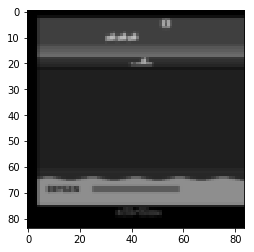

In [181]:
plt.imshow(img)

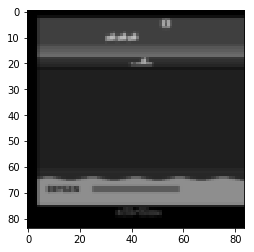

In [183]:
plt.imshow(img);

In [175]:
# https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(np.squeeze(image,-1) )
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plt.show()

In [192]:
prebatch_s,batch_a,batch_r,prebatch_s_,batch_done = agent.longmem.sample(batch_size)# a batch of episode of parameter length

In [194]:
batch_r

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int8)

In [199]:
shortmem_s = agent.shortmem.get()

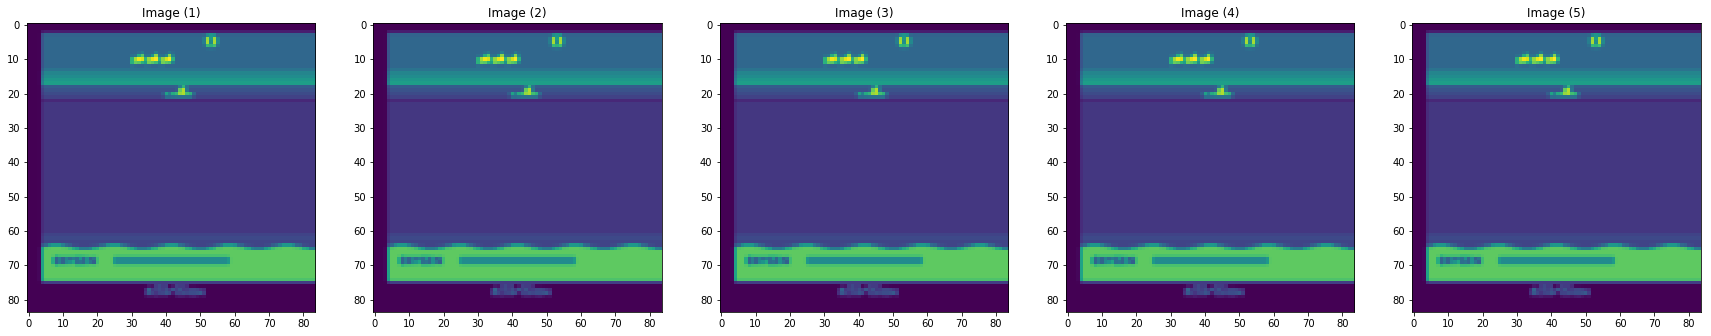

In [200]:
show_images(shortmem_s)

Error starting mission: A mission is already running.
Error starting mission: A mission is already running.


In [23]:
test = [] 
for i in range(1):
    # play loop
    pre_s = atari_env.reset()
    mem_s = pre.process_state_for_memory(pre_s) #scaled and grayscaled
    net_s = pre.process_for_network(mem_s) # normalized
    done = False
    t_agent.shortmem.forget # forget short term memory for recurrent network 
    t_agent.shortmem.add(net_s)
    for t in itertools.count():
        hist_s = t_agent.shortmem.get()
        # take action using net_s and receive a
        a = t_agent.act(hist_s)
        #atari_env.render()

        pre_s_, r, done, info = atari_env.step(a)
        
        mem_s_ = pre.process_state_for_memory(pre_s) #scaled and grayscaled
        net_s_ = pre.process_for_network(mem_s) # normalized
        test.append(mem_s_)
        t_agent.shortmem.add(net_s_)
        t_agent.remember(mem_s,a,r,done)

        #R[-1] += r
        if done:

            #agent.save_scalar(e,"/reward per episode",R[-1])
            #print("episode: {}/{}, score: {}, e: {}".format(e, episodes, t, agent.epsilon))
            #exp.metric("reward",R[-1])
            #update(e,R[-1],handle1,rplot)
            #R = [0.0]
            break


In [312]:
prebatch_s,batch_a,batch_r,prebatch_s_,batch_done = t_agent.longmem.sample(batch_size)# a batch of episode of parameter length

In [313]:
short_mem = t_agent.shortmem.get()

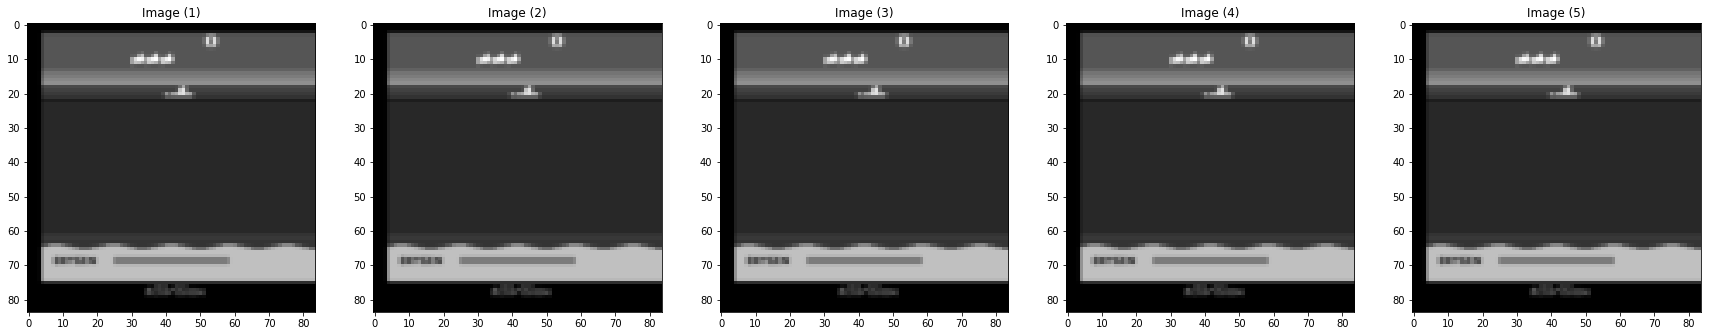

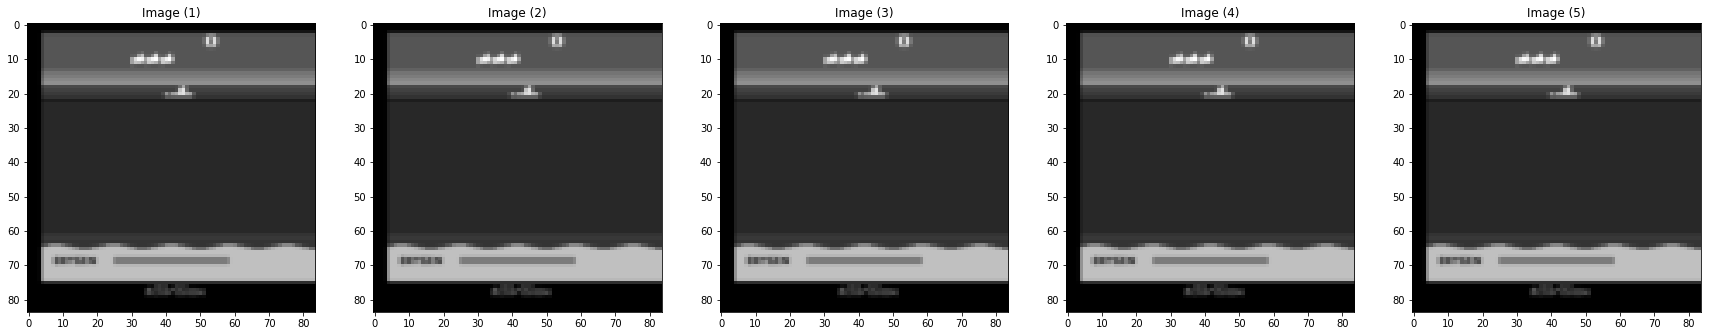

In [314]:
idx = 10
show_images(prebatch_s[idx])
show_images(prebatch_s_[idx])

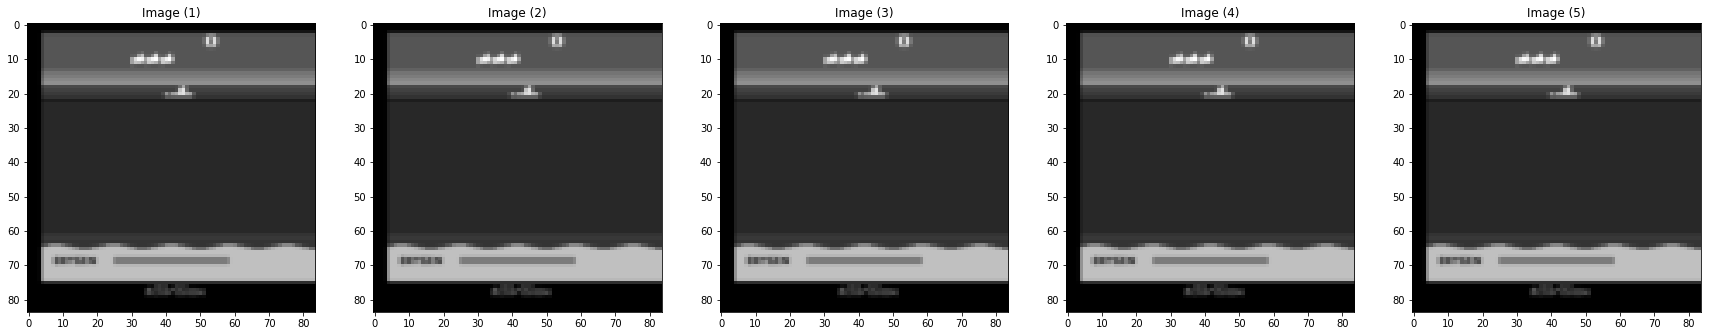

In [315]:
show_images(short_mem)

In [ ]:
len(test)

In [ ]:
show_images(test)

KeyboardInterrupt: 

In [291]:
pre_s = atari_env.reset()
mem_s = pre.process_state_for_memory(pre_s) #scaled and grayscaled
net_s = pre.process_for_network(mem_s) # normalized
done = False
t_agent.shortmem.forget() # forget short term memory for recurrent network 
t_agent.shortmem.add(net_s)
atari_env.render()

In [306]:
a = t_agent.act(hist_s)
atari_env.render()

pre_s_, r, done, info = atari_env.step(a)

mem_s_ = pre.process_state_for_memory(pre_s) #scaled and grayscaled
net_s_ = pre.process_for_network(mem_s) # normalized
t_agent.shortmem.add(net_s_)
t_agent.remember(mem_s,a,r,done)

In [302]:
t_agent.act(hist_s)

13

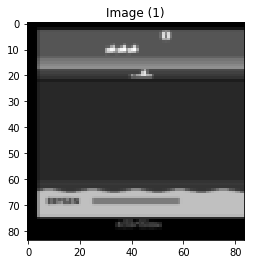

In [285]:
show_images(net_s[None]*255.0)

In [297]:
hist_s = t_agent.shortmem.get()

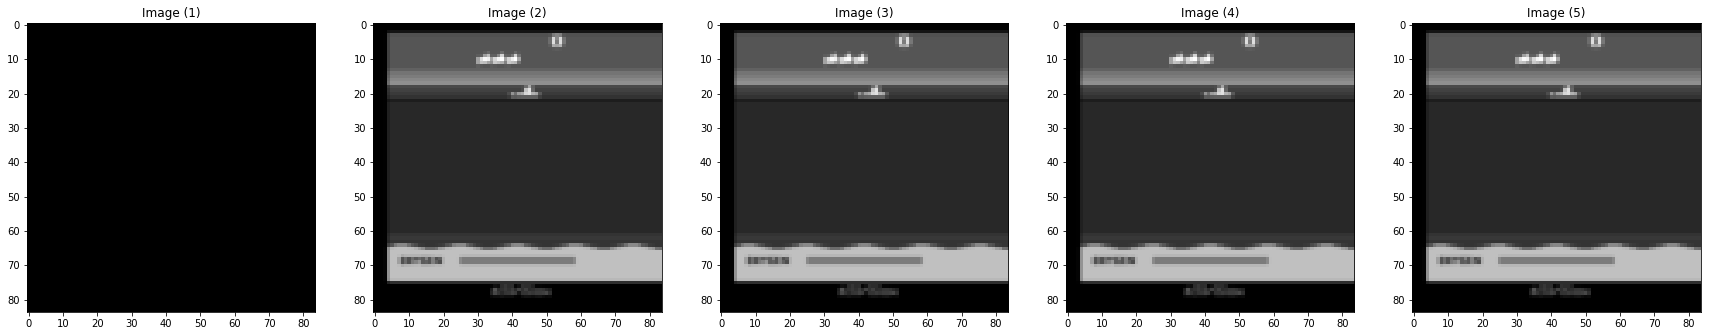

In [298]:
show_images(hist_s*255.0)

In [268]:
t_agent.shortmem.mem_hist.shape

(5, 84, 84, 1)

In [269]:
t_agent.shortmem.current

1